In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных из CSV файла
data = pd.read_csv('loan_approval_dataset.csv')

In [ ]:
# Вывод информации о данных и первых пяти строках для проверки
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Удаление пробелов и приведение к нижнему регистру для категориальных переменных
data['education'] = data['education'].str.strip().str.lower()
data['self_employed'] = data['self_employed'].str.strip().str.lower()
data['loan_status'] = data['loan_status'].str.strip().str.lower()

In [ ]:
# Преобразование категориальных переменных в числовые значения
data['education'] = data['education'].map({'graduate': 1, 'not graduate': 0})
data['self_employed'] = data['self_employed'].map({'yes': 1, 'no': 0})
data['loan_status'] = data['loan_status'].map({'approved': 1, 'rejected': 0})

# Отделение целевой переменной
X = data.drop(['loan_id', 'loan_status'], axis=1)
y = data['loan_status']

# Стандартизация данных
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Определение архитектуры нейронной сети
class CreditApprovalNet(nn.Module):
    def __init__(self):
        super(CreditApprovalNet, self).__init__()
        self.fc1 = nn.Linear(11, 8)  # Входной слой с 11 признаками
        self.fc2 = nn.Linear(8, 16)  # Скрытый слой с 16 нейронами
        self.fc3 = nn.Linear(16, 1)  # Выходной слой с 1 нейроном
        self.relu = nn.ReLU()  # Функция активации ReLU
        self.sigmoid = nn.Sigmoid()  # Функция активации Sigmoid для выходного слоя

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
# Инициализация модели, функции потерь и оптимизатора
model = CreditApprovalNet()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Обучение модели ===
num_epochs = 50
batch_size = 16
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(batch_X)

        # Вычисление функции потерь
        loss = criterion(outputs, batch_y)

        # Обратное распространение
        loss.backward()

        # Обновление параметров
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 0.4746
Epoch [2/50], Loss: 0.3051
Epoch [3/50], Loss: 0.6188
Epoch [4/50], Loss: 0.3760
Epoch [5/50], Loss: 0.0490
Epoch [6/50], Loss: 0.2057
Epoch [7/50], Loss: 0.3086
Epoch [8/50], Loss: 0.0442
Epoch [9/50], Loss: 0.0272
Epoch [10/50], Loss: 0.0977
Epoch [11/50], Loss: 0.0779
Epoch [12/50], Loss: 0.4106
Epoch [13/50], Loss: 0.0116
Epoch [14/50], Loss: 0.1164
Epoch [15/50], Loss: 0.0657
Epoch [16/50], Loss: 0.0407
Epoch [17/50], Loss: 0.0923
Epoch [18/50], Loss: 0.2253
Epoch [19/50], Loss: 0.1894
Epoch [20/50], Loss: 0.0019
Epoch [21/50], Loss: 0.1802
Epoch [22/50], Loss: 0.0329
Epoch [23/50], Loss: 0.1989
Epoch [24/50], Loss: 1.4965
Epoch [25/50], Loss: 0.1812
Epoch [26/50], Loss: 0.0112
Epoch [27/50], Loss: 0.0279
Epoch [28/50], Loss: 0.0215
Epoch [29/50], Loss: 0.0426
Epoch [30/50], Loss: 0.1096
Epoch [31/50], Loss: 0.0777
Epoch [32/50], Loss: 0.0267
Epoch [33/50], Loss: 0.1940
Epoch [34/50], Loss: 0.0239
Epoch [35/50], Loss: 0.0156
Epoch [36/50], Loss: 0.0065
E

In [ ]:
# Прогнозы на тестовых данных
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

# Метрики
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       323
           1       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854

Confusion Matrix:
[[311  12]
 [  8 523]]


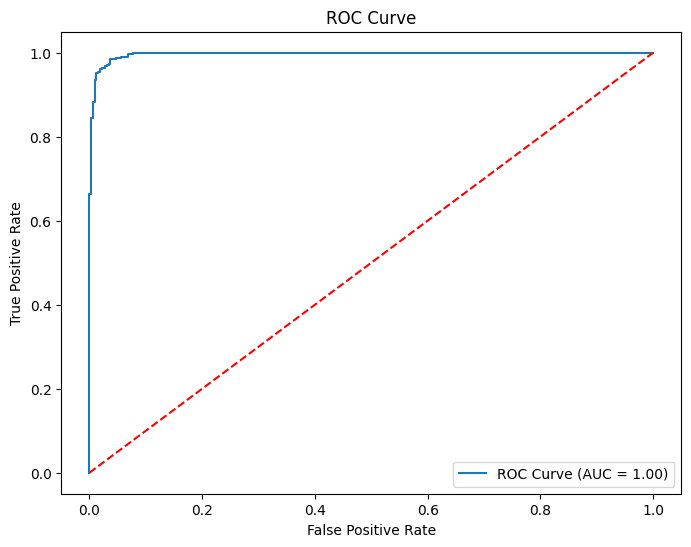

In [ ]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


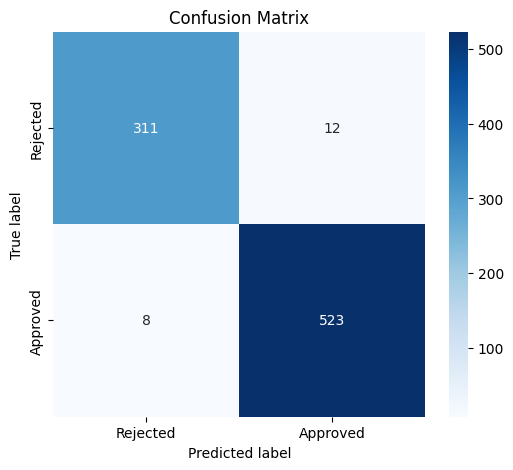

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

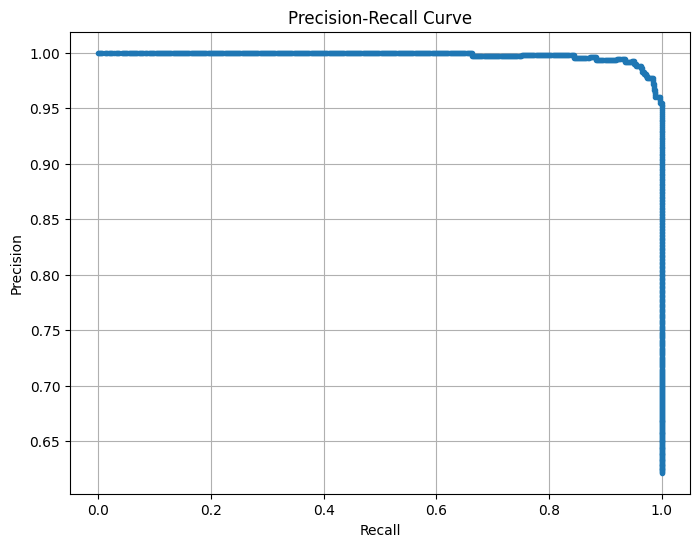

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

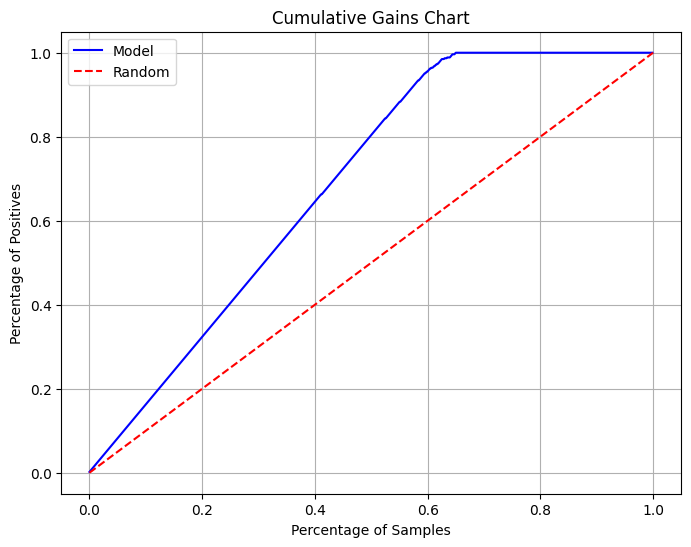

In [ ]:
# Cumulative Gains Chart
sorted_indices = np.argsort(-y_pred_prob.flatten())
sorted_y_test = y_test.values[sorted_indices]
cumulative_positive = np.cumsum(sorted_y_test)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(cumulative_positive)) / len(cumulative_positive),
         cumulative_positive / cumulative_positive[-1], label='Model', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color='red')
plt.xlabel('Percentage of Samples')
plt.ylabel('Percentage of Positives')
plt.title('Cumulative Gains Chart')
plt.legend()
plt.grid()
plt.show()

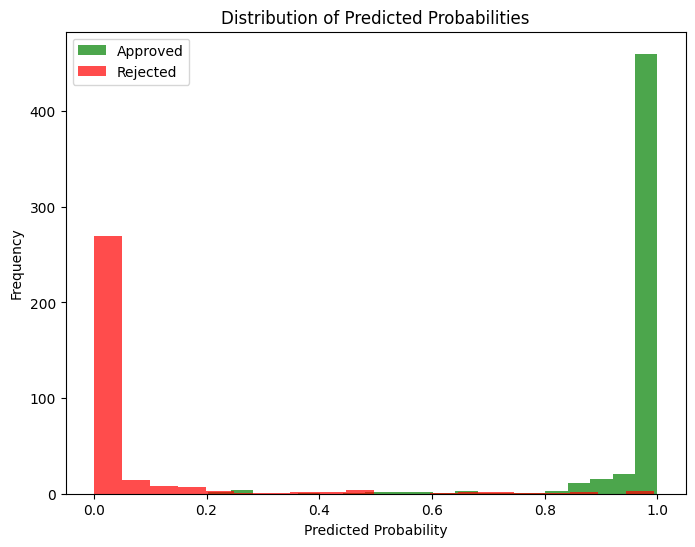

In [ ]:
# Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob[y_test.values == 1], bins=20, alpha=0.7, label='Approved', color='green')
plt.hist(y_pred_prob[y_test.values == 0], bins=20, alpha=0.7, label='Rejected', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

In [ ]:
# Сохранение модели
torch.save(model.state_dict(), 'credit_approval_net.pth')

In [ ]:
# Загрузка модели и предсказание на новых данных
model = CreditApprovalNet()
model.load_state_dict(torch.load('credit_approval_net.pth'))
model.eval()

<ipython-input-36-4bbb73e42998>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('credit_approval_net.pth'))


CreditApprovalNet(
  (fc1): Linear(in_features=11, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
# Пример пользовательских данных
custom_data = {
    'no_of_dependents': [3],
    'education': [1],
    'self_employed': [0],
    'income_annum': [7000000],
    'loan_amount': [20000000],
    'loan_term': [15],
    'cibil_score': [750],
    'residential_assets_value': [5000000],
    'commercial_assets_value': [3000000],
    'luxury_assets_value': [15000000],
    'bank_asset_value': [8000000]
}

custom_data_df = pd.DataFrame(custom_data)
custom_data_scaled = scaler.transform(custom_data_df)
custom_data_tensor = torch.tensor(custom_data_scaled, dtype=torch.float32)

# Предсказание
with torch.no_grad():
    custom_prediction_prob = model(custom_data_tensor).item()
    custom_prediction = 1 if custom_prediction_prob >= 0.5 else 0

status = 'Одобрено' if custom_prediction == 1 else 'Отклонено'
print(f"Результат предсказания для пользовательских данных: {status}")
print(f"Вероятность: {custom_prediction_prob:.2f} для одобрения")

Результат предсказания для пользовательских данных: Одобрено
Вероятность: 1.00 для одобрения
